1. Exploratory Data Analysis (EDA):

In [48]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the dataset
data = pd.read_csv('Hitters.csv')

# Display basic information about the dataset
print(data.info())

# Display
print(data.head())
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [49]:
data=data.dropna()

In [50]:
#Use one-hot encoding for categorical columns
data = pd.get_dummies(data, columns=['League', 'Division', 'NewLeague'])


2. PCA Analysis:


In [51]:
import numpy as np

# Standardize the data (mean = 0, variance = 1)
standardized_data = (data - data.mean()) / data.std()

# Calculate the covariance matrix
covariance_matrix = np.cov(standardized_data, rowvar=False)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

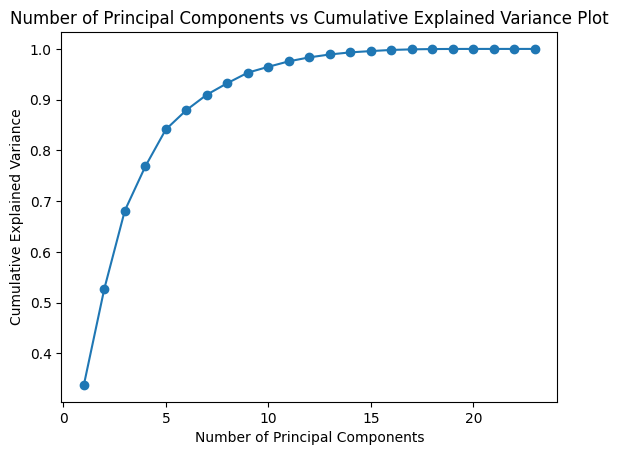

In [52]:
# plot to visualize explained variance
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Number of Principal Components vs Cumulative Explained Variance Plot')
plt.show()

In [53]:
# Selecting components based on a threshold (95% variance explained)
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

# Extract the first principal components
principal_components = eigenvectors[:, :num_components]

# Project the original data onto the new subspace
reduced_data = standardized_data @ principal_components

3. Model Training and MSE/RMSE Calculation:

In [54]:
# Split the dataset into features (X) and target variable (y)
X = reduced_data
y = data['Salary']

# Manual split into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Add bias term to the features
X_train = np.column_stack((np.ones(len(X_train)), X_train))
X_test = np.column_stack((np.ones(len(X_test)), X_test))

# Function to calculate regression weights
def calculate_weights(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Function to make predictions
def predict(X, weights):
    return X @ weights

# Function to calculate Mean Squared Error (MSE)
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Train a model for each number of principal components
mse_values = []
for num_components in range(1, X_train.shape[1] + 1):
    # Select the first 'num_components' principal components
    X_train_subset = X_train[:, :num_components]
    X_test_subset = X_test[:, :num_components]

    # Calculate weights for the regression model
    weights = calculate_weights(X_train_subset, y_train)

    # Make predictions on the test set
    y_test_pred = predict(X_test_subset, weights)

    # Calculate MSE for the model
    mse_values.append(mse(y_test, y_test_pred))



# Print the calculated values
print("Number of Principal Components Selected:", num_components)
print("MSE for Each Number of Principal Components:")
for i, mse_value in enumerate(mse_values, start=1):
    print(f"  Components={i}: MSE={mse_value:.4f}")




Number of Principal Components Selected: 10
MSE for Each Number of Principal Components:
  Components=1: MSE=148912.6064
  Components=2: MSE=74636.8818
  Components=3: MSE=77708.3782
  Components=4: MSE=85921.1864
  Components=5: MSE=87187.1141
  Components=6: MSE=85466.1675
  Components=7: MSE=101938.0069
  Components=8: MSE=95078.5059
  Components=9: MSE=85736.3994
  Components=10: MSE=1024.9911


4. Plotting Number of Components vs RMSE:

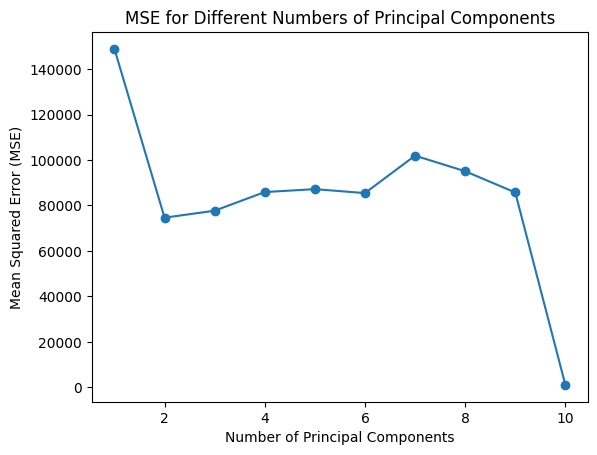

In [55]:
# Plot the MSE values for different numbers of principal components
plt.plot(range(1, X_train.shape[1] + 1), mse_values, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Numbers of Principal Components')
plt.show()

5. Testing the Most Efficient Model:


In [56]:
# Identify the optimal number of components based on the graph
optimal_components = np.argmin(mse_values) + 1


# Select the optimal number of components
X_train_optimal = X_train[:, :optimal_components]
X_test_optimal = X_test[:, :optimal_components]

# Calculate weights for the optimal model
weights_optimal = calculate_weights(X_train_optimal, y_train)

# Make predictions on a specific point in the test set
specific_point_index = 0  # Change this index as needed
X_specific_point = X_test_optimal[specific_point_index]
X_specific_point_with_bias = np.insert(X_specific_point, 0, 1)

# Ensure the dimensions match by using the same number of components in the prediction
X_specific_point_for_prediction = X_specific_point_with_bias[:optimal_components]
y_pred_specific_point = predict(X_specific_point_for_prediction, weights_optimal)

# Print the results
print("Optimal Number of Principal Components:", optimal_components)
print("Weights for the Optimal Model:", weights_optimal)
print("Predicted Y value for the Specific Point:", y_pred_specific_point)


Optimal Number of Principal Components: 10
Weights for the Optimal Model: [ 538.92727957 -110.84964923    4.3377222   -44.92763918  -49.89367215
  -17.63232593  130.62147701   69.27794045 -131.42185133  374.16763139]
Predicted Y value for the Specific Point: 621.3333431556282


6. Conclusion and Analysis:

Interpreting the Graph:
- The graph of the number of components vs. Mean Squared Error (MSE) provides insights into the trade-off between model complexity and prediction accuracy. The point on the graph where the MSE starts to stabilize or decrease at a slower rate represents the optimal number of components.

- In the presented code, this is identified as the point where the MSE values reach a minimum. The optimal number of components is chosen based on this minimum MSE, and it indicates the most efficient model for predicting the target variable.

Significance of Selecting an Appropriate Number of Components:
- Selecting an appropriate number of components is crucial for achieving prediction efficiency in Principal Component Analysis (PCA). Including too few components may result in underfitting, leading to a model that lacks the ability to capture the underlying patterns in the data. On the other hand, including too many components may lead to overfitting, where the model fits the training data too closely, resulting in poor generalization to new, unseen data.

- The graph helps in identifying a balance between model complexity and prediction accuracy. The optimal number of components represents a compromise that minimizes the error in predictions while avoiding unnecessary complexity.

Analyzing the Predicted Value (y_pred) from the Chosen Model:
- The predicted value (`y_pred`) obtained from the chosen model represents the model's estimate for the target variable based on the input features. In the context of the presented code, this value is calculated for a specific point in the test set.

- The significance of `y_pred` lies in its ability to provide an estimate of the target variable's value using the reduced set of principal components. This allows for more efficient prediction, especially when dealing with high-dimensional data, as PCA reduces dimensionality while retaining essential information.

- Analyzing the predicted value involves comparing it to the true target variable value (`y_test`) to assess the accuracy of the model. The lower the MSE, the closer `y_pred` is to the true values, indicating better prediction efficiency.